================================================Word Embedding (word2vec)=======================================

Word vectors are vectors used to represent words, and can also be considered as feature vectors or representations of words. The technique of mapping words to real vectors is called word embedding.

The word2vec tool contains both the skip-gram and continuous bag of words models.

The skip-gram model assumes that a word can be used to generate its surrounding words in a text sequence; while the continuous bag of words model assumes that a center word is generated based on its surrounding context words.


| Symbol             | Meaning                                         | Role in Skip-Gram                                | Role in CBOW                                                                               |
| ------------------ | ----------------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------ |
| $V$                | Vocabulary set                                  | All possible words                               | All possible words                                                                         |
| $T$                | Length of training corpus                       | Sequence positions $t=1\dots T$                  | Same                                                                                       |
| $m$                | Context window size                             | Number of words on either side                   | Same                                                                                       |
| $w_t$              | Word at position $t$ in corpus                  | *Center word* for predicting contexts            | *Target/center word* to be predicted                                                       |
| $w_{t+j}$          | Word at position $t+j$                          | One *context word* to be predicted               | One *context word* used to predict center                                                  |
| $W_c$              | Set of context words around a center            | Not used                                         | $W_c={w_{t+j}: -m\le j\le m,j\ne0}$                                                        |
| $\mathbf{v}_w$     | Input embedding                                 | Vector of the center word $w$                    | Vector of each context word $w$                                                            |
| $\mathbf{u}_w$     | Output embedding                                | Vector of a context word $w$                     | Vector of the target center word $w_t$                                                     |
| $\mathbf{v}_{w_c}$ | Center embedding of word $w_c$                  | Used to score $P(w_o\mid w_c)$                   | Not used                                                                                   |
| $\mathbf{v}_{W_c}$ | *Context summary vector*                        | Not used                                         | Averaged context: $$\mathbf{v}*{W_c}=\frac{1}{2m}\sum*{j=-m,j\ne0}^m\mathbf{v}*{w*{t+j}}$$ |
| $\mathbf{u}_{w_o}$ | Output embedding of word $w_o$                  | Used in softmax score $P(w_o\mid w_c)$           | Not used                                                                                   |
| $\mathbf{u}_{w_t}$ | Output embedding of word $w_t$                  | Not used                                         | Used in softmax score $P(w_t\mid W_c)$                                                     |
| $P(w_o\mid w_c)$   | Predict context word given center               | Modeled by softmax in Skip-Gram                  | —                                                                                          |
| $P(w_t\mid W_c)$   | Predict center given context set                | —                                                | Modeled by softmax in CBOW                                                                 |
| $\hat{y}$          | Model probability output (softmax)              | Softmax over contexts                            | Softmax over center vocab                                                                  |
| Loss               | Negative log-likelihood                         | $$-\sum_{t}\sum_{j\ne0}\log P(w_{t+j}\mid w_t)$$ | $$-\sum_{t}\log P(w_t\mid W_c)$$                                                           |
| SGD                | Stochastic gradient descent                     | Updates $\mathbf{v},\mathbf{u}$                  | Same                                                                                       |


#### The Skip-Gram Model

##### Overview

The **Skip-Gram model** learns word embeddings by predicting **context words** given a **center word**.
It is the core model behind **Word2Vec**, producing dense vectors that capture semantic similarity through shared contexts.

**Example:**  
For the sentence *“the man loves his son”*, with center word *“loves”* and window size $m=2$, the model predicts:
$\{\text{the}, \text{man}, \text{his}, \text{son}\}$.

##### 1️. Conditional Independence Assumption

Skip-Gram assumes context words are **conditionally independent** given the center word $w_t$:

$$
P(\{w_{t+j}\}_{j \neq 0} \mid w_t)
=
\prod_{\substack{-m \le j \le m \\ j \neq 0}}
P(w_{t+j} \mid w_t).
$$

This simplifies learning by treating each center–context pair independently.

##### 2️. Probability Model (Softmax)

Each word $w \in V$ has two vector representations:

- $\mathbf{v}_w$: **center (input) embedding**
- $\mathbf{u}_w$: **context (output) embedding**

The probability of observing a context word $w_o$ given a center word $w_c$ is:

$$
P(w_o \mid w_c)
=
\frac{\exp(\mathbf{u}_{w_o}^T \mathbf{v}_{w_c})}
{\sum_{w \in V} \exp(\mathbf{u}_w^T \mathbf{v}_{w_c})}.
$$

The softmax normalizes scores over the entire vocabulary.

##### 3️. Objective Function

Given a corpus $\{w_1,\dots,w_T\}$ and window size $m$, Skip-Gram maximizes the likelihood:

$$
\prod_{t=1}^{T}
\prod_{\substack{-m \le j \le m \\ j \neq 0}}
P(w_{t+j} \mid w_t).
$$

Equivalently, it minimizes the **average negative log-likelihood**:

$$
\mathcal{L}
=
-\frac{1}{T}
\sum_{t=1}^{T}
\sum_{\substack{-m \le j \le m \\ j \neq 0}}
\log P(w_{t+j} \mid w_t).
$$

##### 4. Training Procedure

The parameters $\{\mathbf{v}_w, \mathbf{u}_w\}_{w \in V}$ are learned by minimizing $\mathcal{L}$ using
**stochastic gradient descent (SGD)**.

At each step:
- sample a center word $w_c$,
- sample its context words $w_o$ within window $m$,
- update the corresponding embeddings.

##### 5️. Gradient Computation

For a single center–context pair $(w_c, w_o)$:

$$
\log P(w_o \mid w_c)
=
\mathbf{u}_{w_o}^T \mathbf{v}_{w_c}
-
\log \sum_{w \in V} \exp(\mathbf{u}_w^T \mathbf{v}_{w_c}).
$$

**Gradient w.r.t. center embedding $\mathbf{v}_{w_c}$:**

$$
\frac{\partial \log P(w_o \mid w_c)}{\partial \mathbf{v}_{w_c}}
=
\mathbf{u}_{w_o}
-
\sum_{w \in V} P(w \mid w_c)\mathbf{u}_w.
$$

**Gradient w.r.t. context embedding $\mathbf{u}_{w_o}$:**

$$
\frac{\partial \log P(w_o \mid w_c)}{\partial \mathbf{u}_{w_o}}
=
\mathbf{v}_{w_c}\bigl(1 - P(w_o \mid w_c)\bigr).
$$

##### 6️. Intuition

- Skip-Gram learns by **predicting context from center words**.
- Words that appear in similar contexts are pushed toward **similar embeddings**.
- After training:
  - $\mathbf{v}_w$: commonly used as the final **word embedding**
  - $\mathbf{u}_w$: represents **context-specific embeddings**

The model encodes semantic similarity through shared prediction tasks.

#### The Continuous Bag of Words (CBOW) Model

##### Overview

The **Continuous Bag of Words (CBOW)** model learns word representations by **predicting a center word from its surrounding context words**. It is the inverse of the **Skip-Gram** model, which predicts context words from a center word.

**Example:**  
For the sentence *“the man loves his son”* with window size $m=2$, the context words $\{\text{the}, \text{man}, \text{his}, \text{son}\}$ are used to predict the center word *“loves”*.

##### 1️. Context Representation

Let the context of center word $w_t$ be:
$$
W_c = \{\,w_{t+j}:\ -m \le j \le m,\ j \ne 0\,\}.
$$

Each word $w \in V$ has two vector representations:
- $\mathbf{v}_w$: **input (context) vector**
- $\mathbf{u}_w$: **output (center/target) vector**

CBOW represents the context by averaging the input vectors:
$$
\mathbf{v}_{W_c}
=
\frac{1}{2m}
\sum_{\substack{-m \le j \le m \\ j \ne 0}}
\mathbf{v}_{w_{t+j}}.
$$

This mirrors Skip-Gram’s use of a single center vector $\mathbf{v}_{w_c}$, but aggregates multiple context vectors instead.

##### 2️. Softmax Probability

Given the aggregated context vector $\mathbf{v}_{W_c}$, the probability of predicting the center word $w_t$ is:

$$
P(w_t \mid W_c)
=
\frac{\exp(\mathbf{u}_{w_t}^\top \mathbf{v}_{W_c})}
{\sum_{w \in V} \exp(\mathbf{u}_w^\top \mathbf{v}_{W_c})}.
$$

This is a softmax over the vocabulary $V$, analogous to Skip-Gram’s
$P(w_o \mid w_c)$ formulation.

##### 3️. Objective Function

Given a corpus $\{w_1,\dots,w_T\}$, CBOW maximizes the likelihood:
$$
\prod_{t=1}^{T}
P(w_t \mid w_{t-m}, \ldots, w_{t+m}).
$$

Equivalently, it minimizes the **negative log-likelihood**:
$$
\mathcal{L}
=
- \sum_{t=1}^{T}
\log P(w_t \mid W_c).
$$

This has the same structure as Skip-Gram, with center and context roles reversed.

##### 4️. Training Procedure

CBOW is trained using **stochastic gradient descent (SGD)**.

At each step:
- sample a center word $w_t$ and its context $W_c$,
- compute the averaged context vector,
- update the corresponding $\mathbf{v}_w$ and $\mathbf{u}_w$.

Averaging context vectors makes CBOW computationally efficient.

##### 5️. Gradient Computation

For a single training pair $(W_c, w_t)$:
$$
\log P(w_t \mid W_c)
=
\mathbf{u}_{w_t}^\top \mathbf{v}_{W_c}
-
\log \sum_{w \in V} \exp(\mathbf{u}_w^\top \mathbf{v}_{W_c}).
$$

**Gradient with respect to a context embedding $\mathbf{v}_{w_i}$:**
$$
\frac{\partial \log P(w_t \mid W_c)}{\partial \mathbf{v}_{w_i}}
=
\frac{1}{2m}
\left(
\mathbf{u}_{w_t}
-
\sum_{w \in V} P(w \mid W_c)\mathbf{u}_w
\right).
$$

Each context word receives an equal share of the gradient due to averaging.

##### 6️. Intuition

- CBOW predicts **one center word** from **many context words**.
- Context embeddings are averaged to form a single representation.
- Words appearing in similar contexts learn similar embeddings.


Due to the nature of the softmax operation, since a context word may be anyone in the dictionary, the opposite of avove algorithm contains the summation of items as many as the entire size of the vocabulary. Consequently, the gradient calculation for the skip-gram model and that for the continuous bag-of-words model both contain the summation. Unfortunately, the computational cost for such gradients that sum over a large dictionary (often with hundreds of thousands or millions of words) is huge!
In order to reduce the computational complexity, this section will introduce two approximate training methods: **negative sampling** and **hierarchical softmax**. 

#### Negative Sampling

##### Overview

The original Skip-Gram objective uses a full softmax over the entire vocabulary $∣𝑉∣$, which is computationally expensive because it requires updating gradients for all words.

Instead of updating **all word vectors**, it updates only: - the **positive example** (true context word)\- **K negative samples** (noise words). This makes training fast and scalable.

##### 1️. Positive Example Probability

Given a center word $w_c$ and true context word $w_o$:

$$
P(D = 1 \mid w_c, w_o) = \sigma(\mathbf{u}_{w_o}^ T \mathbf{v}_{w_c})
$$

Sigmoid:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

##### 2. Why Negative Sampling?

The original Skip-Gram objective considers only **positive examples**, which leads to:
- $\prod_{t=1}^{T} \prod_{-m<=j<=m, j \ne 0}P(D = 1 \mid w^{(t)}, w^{(t+j)})$ Only maximizes when all word vectors grow to infinity → meaningless maximization (vectors blow up to infinity) 
- extremely expensive softmax (needs $|V|$ updates)

Negative sampling fixes both.

##### 3. How Negative Sampling Works

For each positive pair ($w_c$, $w_o$):
- Draw **K negative samples** $w_k$ from noise distribution $P(w)$
- Treat them as "fake context words" with label $D=0$

The new objective approximation:

$$
P(w_o \mid w_c) \approx 
P(D = 1 \mid w_c, w_o)
\prod_{k=1}^{K} P(D = 0 \mid w_c, w_k)
$$

##### 4. Loss Function

Let $i$ = index of center word, $h$ = index of true context word:

$$
-\log \sigma(\mathbf{u}_{h}^ T \mathbf{v}_{i})
-
\sum_{k=1}^{K} \log(1 - \sigma(\mathbf{u}_{k}^ T \mathbf{v}_{i}))
$$

Equivalent form:

$$
-\log \sigma(\mathbf{u}_{h}^ T \mathbf{v}_{i})
+
\sum_{k=1}^{K} \log \sigma(-\mathbf{u}_{k}^ T \mathbf{v}_{i})
$$

**Meaning:** 
- Positive pair → push dot product higher
- Negative pairs → push dot products lower

##### 5️. Computational Efficiency

With negative sampling: - Computation depends only on **K**, not vocabulary size
- Typical K = 5 to 20
- Enables training on large corpora quickly

Negative sampling reduces training to a scalable binary classification problem.

#### Hierarchical Softmax

##### Overview

Hierarchical softmax is an efficient alternative to the traditional softmax used in Word2Vec. Instead of computing probabilities over the entire vocabulary $|V|$,
it organizes all words into a **binary tree**, where each **leaf node** corresponds to a word.

Predicting a word becomes making a sequence of **binary decisions** along the path from the root to that word's leaf node.

This reduces computational cost from:

$$
O(|V|) \quad \rightarrow \quad O(\log |V|)
$$

##### 1️. Tree Structure

- Each word $w$ is represented as a **leaf node**.
- Let $L(w)$ be the number of nodes on the path (including the leaf).
- Let $n(w, j)$ denote the $j$-th node on the path.
- Each **internal node** $n$ has an associated vector $\mathbf{u}_n$.
- Each internal node performs a **binary decision**:
  - go **left**
  - or go **right**

Thus, predicting a word is equivalent to predicting the correct sequence of left/right decisions.


![Hierarchical softmax](./Images/hierarchicalSoftmax.png)

##### 2️. Probability of a Word

Hierarchical softmax models
$$
P(w_o \mid w_c)
$$
as the probability of making **all correct binary decisions** along the path from the root to word $w_o$.

##### Binary Decision at One Node

At internal node $n$, given center word $w_c$, define:
$$
P(\text{go left at } n \mid w_c)
= \sigma(\mathbf{u}_n^\top \mathbf{v}_{w_c}),
$$

$$
P(\text{go right at } n \mid w_c)
= 1 - \sigma(\mathbf{u}_n^\top \mathbf{v}_{w_c})
= \sigma(-\mathbf{u}_n^\top \mathbf{v}_{w_c}),
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$.

##### Encoding the Correct Direction

Define a sign function:
$$
\delta(w_o, j)
=
\begin{cases}
+1, & \text{if } n(w_o, j+1) \text{ is the left child of } n(w_o, j), \\
-1, & \text{if } n(w_o, j+1) \text{ is the right child}.
\end{cases}
$$

This encodes whether the correct decision at node $n(w_o,j)$ is **left** or **right**.

##### Full Probability Formula

The probability of generating word $w_o$ is the product of correct binary decisions:

$$
P(w_o \mid w_c)
=
\prod_{j = 1}^{L(w_o)-1}
\sigma\!\left(
\delta(w_o, j)\,
\mathbf{u}_{n(w_o, j)}^\top
\mathbf{v}_{w_c}
\right).
$$

Each term is the probability of choosing the correct branch at one node.


Or the formula can be written as:

$$
P(w_o \mid w_c)
=
\prod_{j = 1}^{L(w_o)-1}
\sigma\left(
\big[ n(w_o, j+1) = \text{leftChild}(n(w_o, j)) \big]
\cdot
\mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_{w_c}
\right)
$$

Where:
-   The bracket equals **+1** if the next node is the left child
-   Equals **-1** if the next node is the right child

So the model learns to output a correct sequence of binary choices leading to the target word’s leaf.

##### 3️. Example

For word $w_3$, suppose the path is:

-   root → left → right → leaf

Probability becomes:

$$
P(w_3 \mid w_c)
=
\sigma(\mathbf{u}_{n_1}^T \mathbf{v}_{w_c})
\cdot
\sigma(-\mathbf{u}_{n_2}^T \mathbf{v}_{w_c})
\cdot
\sigma(\mathbf{u}_{n_3}^T \mathbf{v}_{w_c})
$$

##### 4️. Valid Probability Distribution

Hierarchical softmax ensures that:

$$
\sum_{w \in V} P(w \mid w_c) = 1
$$

even though it bypasses the full softmax.

##### Key Takeaways

-   Converts predicting a word into making $\log |V|$ binary decisions.
-   Efficient for large vocabularies.
-   Widely used in Word2Vec models.
-   Provides a scalable alternative to full softmax.


================================================The Dataset for Pretraining Word Embeddings=======================================

In [1]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip','319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

#### Subsampling

##### Why Subsampling?

In natural language corpora, **high-frequency words** (e.g., “the”, “a”, “in”) appear extremely often.
These words contribute little semantic information for learning word embeddings, yet they dominate
training examples and slow down optimization.

Subsampling addresses this by **randomly discarding frequent words** before training.

##### What Subsampling Achieves

Subsampling:
- Reduces the number of trivial and redundant training pairs
- Speeds up training
- Emphasizes informative word co-occurrences
- Improves the quality of learned embeddings

Rare words are kept almost always, while very frequent words are often removed.

##### Subsampling Rule

For each word token $w_i$ in the corpus, the probability of **keeping** it is:

$$
P(\text{keep } w_i)
= \sqrt{\frac{t}{f(w_i)}},
$$

and the probability of **discarding** it is:

$$
P(\text{discard } w_i)
= \max\left(1 - \sqrt{\frac{t}{f(w_i)}},\, 0\right),
$$

where:
- $f(w_i)$ is the relative frequency of word $w_i$ in the corpus
- $t$ is a small threshold (typically $10^{-4}$)

##### Intuition

- If $f(w_i) \ll t$:  
  the word is rare → almost always kept
- If $f(w_i) \gg t$:  
  the word is very frequent → likely to be discarded

This selectively removes words that carry little semantic signal.

##### Effect on the Dataset

After subsampling:
- Sentences become shorter
- Context windows contain more informative words
- The effective training corpus is smaller but higher quality

This preprocessing step is crucial for efficient and effective training of


In [4]:
#@save
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = collections.Counter([token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

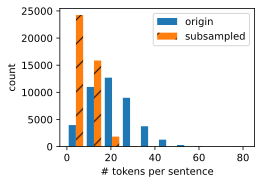

In [5]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

In [6]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'# of "the": before=50770, after=2016'

In [7]:
compare_counts('join')

'# of "join": before=45, after=45'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [6697, 4127, 3228, 4060], [3922, 1922, 4743]]

Extracting Center Words and Context Words

The `get_centers_and_contexts` function below processes the corpus to generate training examples for word embedding models.

**Core Idea**

- Each word in the corpus is treated as a **center word**.
- For every center word, a **context window size** is sampled **uniformly at random**
  from the range: $\{1, 2, \ldots, \text{max\_window\_size}\}.$

**Context Selection**

Given a center word at position $t$ and a sampled window size $m$:
- All words whose positions satisfy $|j - t| \le m, \quad j \ne t$ are selected as its **context words**.
This means the context window varies across training examples. **Each training example has its own context window size.**

**Why Random Window Sizes?**

- Introduces variability in context ranges
- Prevents overemphasis on fixed-distance neighbors
- Improves robustness and generalization of learned embeddings

**Output**

The function returns:
- a list of **center words**
- a corresponding list of **context word lists**

Each center word is paired with its dynamically sampled context.

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word -- context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [11]:
# When training on the PTB dataset, we set the maximum context window size to 5. The following extracts all the center words and their context words in the dataset.

all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}'

'# center-context pairs: 1497733'

**Negative Sampling: Noise Word Generation**

To enable **approximate training** with negative sampling, noise words must be drawn from a predefined probability distribution.

**Core Idea**

- Negative sampling requires repeatedly drawing **noise words** according to a fixed distribution.
- The distribution is specified via **sampling weights**, which may be unnormalized.
- Efficient sampling is crucial because noise words are generated frequently during training.

**RandomGenerator class**

this class provides an efficient mechanism to perform this sampling during training:
- accept a list of `sampling_weights` (e.g., proportional to $f(w)^{0.75}$), `sampling_weights` define how likely each word is to be sampled.
- efficiently sample word indices according to these weights,
- avoid repeatedly recomputing the distribution.

This abstraction allows negative sampling to be fast, reusable, and decoupled
from the rest of the training pipeline.

In [12]:
# negative sampling for picking noise words

#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000) # sample 10000 at first, later it will be used one by one
            # print(self.candidates)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [13]:
# For example, we can draw 10 random variables X among indices 1, 2, and 3 with sampling probabilities P(X=1)=2/9, P(X=2)=3/9, P(X=3)=4/9 as follows.

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 2, 1, 2, 1, 2, 3, 1, 2]

In [14]:
# For a pair of center word and context word, we randomly sample K (5 in the experiment) noise words. 
# In the word2vec paper, the sampling probability P(w) of a noise word is set to its relative frequency in the dictionary raised to the power of 0.75

#@save
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

Loading Training Examples in Minibatches

After extracting **center words**, **context words**, and **negative samples**, the data must be organized into **minibatches** so it can be efficiently fed into the training loop.

**Challenge**: Variable-Length Contexts

- Each training example consists of:
  - one center word
  - a variable number of context words
  - a variable number of negative samples
- Because context window sizes vary, the total number of context + negative words differs across examples.

**Key Idea**: Padding + Masking

To batch examples together:
1. Concatenate context words and negative words into one list:
contexts_negatives
2. Pad with zeros so all examples reach the same length:
max_len = max length in the batch
3. Create a mask to ignore padded positions during loss computation.

For each minibatch:
- **centers**  
Center word indices (shape: `batch_size × 1`)

- **contexts_negatives**  
Concatenated context + negative word indices, padded to `max_len`

- **masks**  
Binary mask with:
- `1` → valid word
- `0` → padding (ignored in loss)

- **labels**  
Binary labels aligned with `contexts_negatives`:
- `1` → context word (positive example)
- `0` → negative sample

Each element in `masks` and `labels` corresponds one-to-one with `contexts_negatives`.

**Why Masks and Labels Are Needed**

- **Masks** ensure padding tokens do not affect loss or gradients.
- **Labels** distinguish:
  - real context words (positive)
  - noise words (negative)

This setup supports **negative sampling loss** in minibatch form.

**Implementation Note**

A `batchify` function:
- takes a list of examples `(center, context, negative)`
- pads and packs them into tensors
- returns all variables needed for training (`centers`, `contexts_negatives`, `masks`, `labels`)

**Summary**

- Minibatching requires handling variable-length context windows
- Padding + masking makes batching possible
- Labels separate positive and negative samples
- This structure enables efficient training with negative sampling





In [15]:
#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), 
            torch.tensor(contexts_negatives), 
            torch.tensor(masks),
            torch.tensor(labels))

In [16]:
x_1 = (1, [2, 4], [5, 6, 7, 8, 9, 10])               # (center, context, negative), len(negative) is usually = len(context) * K
x_2 = (3, [1, 2, 4], [6, 7, 8, 9, 10, 11, 12, 13, 14])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [3]])
contexts_negatives = tensor([[ 2,  4,  5,  6,  7,  8,  9, 10,  0,  0,  0,  0],
        [ 1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
masks = tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
labels = tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [17]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify,
                                      num_workers=num_workers)
    return data_iter, vocab

In [18]:
data_iter, vocab = load_data_ptb(batch_size = 512, max_window_size = 5, num_noise_words = 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


- context_size max is: 2 * max_window_size = 10
- contexts_negatives = context words + negative words = context_size + max_window_size * context_size = 60

======================================Pretraining word2vec=============================================

In [19]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

An **embedding layer** maps token indices to dense vector representations. It is a lookup table: indices in, vectors out — with one vector per token.

- The input to an embedding layer is a tensor of **token indices**.
- Each token index $i$ corresponds to the $i$-th row of the embedding
  weight matrix.
- The embedding dimension is set by `output_dim`.

If:
- input shape = $(2, 3)$ (two examples, three tokens each)
- embedding dimension = $4$

Then:
- output shape = $(2, 3, 4)$

Each token index is replaced by its corresponding 4-dimensional embedding vector.



In [20]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4) # (vocab_size, embed_size)
print(f'Parameter embedding_weight ({embed.weight.shape}, 'f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [21]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]]) # (2, 3) -> (2, 3, 4)
embed(x)

tensor([[[ 0.3308, -0.3372, -0.8600, -0.7603],
         [-0.3090,  1.6024,  0.8086,  0.6145],
         [-0.5710, -2.2856,  0.0814, -0.6121]],

        [[ 1.0145, -0.7849, -0.8184,  0.1040],
         [ 0.0043, -1.2932,  0.6911, -1.7616],
         [-0.2732, -0.4100,  0.4556,  0.1090]]], grad_fn=<EmbeddingBackward0>)

In [22]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    # center: (batch size, 1)
    # contexts_and_negatives: (batch size, max_len)
    v = embed_v(center) # (batch size, 1, embed_size)
    u = embed_u(contexts_and_negatives) # (batch size, max_len, embed_size)
    pred = torch.bmm(v, u.permute(0, 2, 1)) # (batch size, 1, max_len)
    return pred

In [23]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [24]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [25]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [26]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [27]:
# define two embedding layers for all the words in the vocabulary when they are used as center words and context words, respectively. 

embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size), # center word embedding
                    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size)) # context word embedding

In [28]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask) / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.410, 71561.4 tokens/sec on cpu


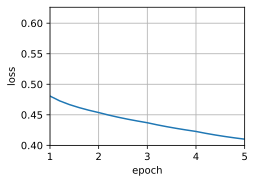

In [29]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    # torch.mv: matrix-vector product
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.699: microprocessor
cosine sim=0.699: drives
cosine sim=0.681: chips


=====================Word Embedding with Global Vectors (GloVe)=========================

#### Skip-Gram with Global Corpus Statistics (SG-GCS)

##### Overview
- Defines $ q_{ij} = P(w_j \mid w_i) $, the conditional probability of context word $ w_j $ given center word $ w_i $.  
- Computed via softmax: $ q_{ij} = \frac{\exp(u_j \cdot v_i)}{\sum_k \exp(u_k \cdot v_i)} $

##### Key Idea
- Uses **global co-occurrence statistics** rather than sliding local windows.  
- Let $ x_{ij} $ be the number of times $ w_j $ appears in the context of $ w_i $.  
- Objective:
  $ J = - \sum_i \sum_j x_{ij} \log q_{ij} $
- Equivalent form:
  $ J = - \sum_i x_i \sum_j p_{ij} \log q_{ij}, \quad p_{ij} = \frac{x_{ij}}{x_i} $

##### Interpretation
- $ \sum_j p_{ij} \log q_{ij} $ is the **cross-entropy** between:
  - empirical distribution $ p_{ij} $ (from corpus counts), and  
  - model distribution $ q_{ij} $, weighted by $ x_i $.
- Minimizing this loss aligns model predictions with corpus statistics.

- Disadvantages:
  - Full softmax over the vocabulary is computationally expensive.
  - Rare words can dominate the loss:
    - The loss sums over **all observed (center, context) pairs**.
    - Many rare words appear only once or twice.
    - For rare pairs, $ \hat{p}(c \mid w) $ is very small, so $ -\log \hat{p}(c \mid w) $ is large.
    - Despite being rare, such events produce large gradients.
    - In large corpora, many rare pairs accumulate → unstable or skewed embeddings.

#### The GloVe Model

##### Motivation
The **GloVe (Global Vectors)** model addresses these issues by:
- replacing cross-entropy with a **squared loss**, and  
- directly modeling **log co-occurrence counts / ratios**, rather than probabilities.

##### Main Changes
1. Replace probabilities with co-occurrence counts:
   $ f_{ij} = x_{ij}, \quad \hat{f}_{ij} = \exp(u_j \cdot v_i) $

2. Use a **squared error objective**:
   $ J = (u_j \cdot v_i + b_i + c_j - \log x_{ij})^2 $

3. Add a **weighting function** to control frequent and rare pairs:
   $$
   h(x_{ij}) =
   \begin{cases}
   (x_{ij}/a)^\alpha, & x_{ij} < a \\
   1, & \text{otherwise}
   \end{cases}
   $$
   Typical values: $ a = 100 $, $ \alpha = 0.75 $.

##### Final GloVe Loss Function
$ J = \sum_{i,j} h(x_{ij}) \, (u_j \cdot v_i + b_i + c_j - \log x_{ij})^2 $

##### Intuition
- GloVe learns embeddings where **vector differences encode semantic relationships**.  
- The weighting function stabilizes training by:
  - down-weighting very rare pairs, and  
  - preventing extremely frequent pairs from dominating.
- The formulation is symmetric in $ (w_i, w_j) $, yielding comparable embeddings when roles are swapped.


#### Interpreting GloVe from the Ratio of Co-occurrence Probabilities

##### Core Concept
Let $p_{ij} = P(w_j \mid w_i)$ be the conditional probability of word $w_j$ appearing in the context of $w_i$.  
The **ratio** $p_{ij} / p_{ik}$ captures how strongly different context words distinguish the meaning of $w_i$.

##### Example
| Context Word | solid | gas | water | fashion |
|---------------|-------|-----|--------|----------|
| $p_1 = P(w_j \mid ice)$   | 0.00019 | 0.000066 | 0.003  | 0.000017 |
| $p_2 = P(w_j \mid steam)$ | 0.000022| 0.00078  | 0.0022 | 0.000018 |
| Ratio ($p_1/p_2$)         | 8.9     | 0.085    | 1.36   | 0.96     |

Observations:
- **solid** is strongly associated with *ice* → large ratio (8.9).
- **gas** is strongly associated with *steam* → small ratio (0.085).
- **water** relates to both → ratio ≈ 1.
- **fashion** is unrelated → ratio ≈ 1 but semantically uninformative.

##### Mathematical View
We want a function $f$ such that:
$$
f(w_i, w_j, w_k) \approx \frac{P_{ij}}{P_{ik}}
$$

A natural exponential form using embeddings is:
$$
f(w_i, w_j, w_k)
= \frac{\exp(u_i^\top v_j)}{\exp(u_i^\top v_k)}
= \exp\!\big((v_j - v_k)^\top u_i\big)
$$

Equating both sides:
$$
\exp\!\big((v_j - v_k)^\top u_i\big) \approx \frac{P_{ij}}{P_{ik}}
$$

Taking logs:
$$
(v_j - v_k)^\top u_i = \log P_{ij} - \log P_{ik}
$$

This implies each dot product should match log co-occurrence probabilities (up to bias):
$$
u_i^\top v_j + b_i + c_j \approx \log P_{ij}
$$

Since $P_{ij} = \frac{x_{ij}}{x_i}$, the normalization term $\log x_i$ can be absorbed into $b_i$:
$$
u_i^\top v_j + b_i + c_j \approx \log x_{ij}
$$

##### Learning Objective
To satisfy this relation across all word pairs, GloVe minimizes a **weighted least-squares loss**:
$$
J = \sum_{i,j} f(x_{ij}) \, (u_i^\top v_j + b_i + c_j - \log x_{ij})^2
$$

The weighting function limits extreme frequencies:
$$
f(x) =
\begin{cases}
(x / x_{\text{max}})^\alpha, & x < x_{\text{max}} \\
1, & x \ge x_{\text{max}}
\end{cases}
$$

Common values: $x_{\text{max}} = 100$, $\alpha = 0.75$.

##### Intuition
- GloVe models **semantic meaning via ratios of co-occurrence probabilities**, not raw probabilities.
- Embeddings are learned so **vector differences encode log co-occurrence ratios**, e.g.  
  $$
  \text{king} - \text{man} + \text{woman} \approx \text{queen}
  $$
  $$
  \text{ice} - \text{steam} + \text{solid} \approx \text{gas}
  $$
- **Why log ratios?**
  - Convert multiplicative relationships into linear ones
  - Reduce sensitivity to extreme probabilities
- **Why GloVe > SG-GCS**
  - Smooth, weighted loss (robust to rare counts)
  - No expensive global softmax
  - Directly captures semantic regularities
  - Trains efficiently from the co-occurrence matrix

=========================================Subword Embedding=======================================

#### The fastText Model

##### Key Idea
- In **word2vec**, each *word* is assigned a single embedding vector.
- In **fastText**, each *word* is represented as the **sum of its character n-gram (subword) embeddings**.

This design captures **morphological structure** (prefixes, suffixes, roots) and enables meaningful representations for **rare or unseen words**.

##### How Subwords Are Built
1. Add boundary symbols `<` and `>` to mark word start and end.  
   Example: `"where"` → `"<where>"`.
2. Extract all character n-grams of lengths typically between 3 and 6:
   - Examples: `"<wh"`, `"whe"`, `"her"`, `"ere"`, `"re>"`, `"wher"`, `"here"`, `"<whe"`, …
3. Each distinct n-gram is treated as a **subword unit** and assigned its own embedding vector.

> Subwords are **not linguistically predefined**.  
> They are generated deterministically from raw character strings and learned purely from data.

##### How Subwords Are Discovered / Learned
- fastText does **not** discover subwords via clustering or segmentation.
- Instead:
  - All possible n-grams in the chosen length range are generated.
  - Each n-gram is mapped (often via hashing) to an embedding index.
  - During training, gradients flow to subword embeddings whenever their parent word appears.
- Over time, useful subwords (e.g., “ing”, “tion”, “un”, “pre”) acquire meaningful vectors because they recur across many words.

##### Word Representation
If a word $w$ has a set of subwords $G_w$, its embedding is: $ v_w = \sum_{g \in G_w} z_g $, where $z_g$ is the embedding of subword $g$.
Thus, a word’s meaning is the **sum of its subword meanings**.

##### Training Objective
- fastText uses the **same objectives as word2vec**:
  - Skip-gram with negative sampling (most common)
  - CBOW
- The only change is that the *input word vector* is replaced by the sum of its subword vectors.

##### Advantages
- **Robust to rare and OOV words**:  
  Even unseen words can be embedded via known subwords.
- **Parameter sharing across morphology**:  
  Words like *run*, *running*, *runner*, *runs* share many subwords → better generalization.
- **Captures spelling–meaning correlations**, useful for morphologically rich languages.

##### Trade-offs
- **Higher memory usage**: many subword embeddings.
- **More computation**: word vectors require summing multiple n-gram vectors at each update.
- Uses hashing to control vocabulary size, which can introduce collisions (usually minor in practice).

#### Byte Pair Encoding (BPE)

##### Motivation
FastText fixes subword length (e.g., 3–6 characters).  
To allow *variable-length subwords* and a *controlled vocabulary size*, **Byte Pair Encoding (BPE)** is used.

##### How BPE Works
1. **Start** with all characters as basic symbols (e.g., `'a', 'b', ..., 'z', '_', [UNK]`).
2. **Count frequencies** of all symbol pairs (like `'t'` + `'h'` → `'th'`).
3. **Merge the most frequent pair** into a new symbol.
4. **Repeat** until you reach a target vocabulary size.

The result is a vocabulary of subwords that frequently appear together, efficiently capturing both characters and common morphemes.

##### Example (simplified)
Initial symbols: `["l", "o", "w", "e", "r"]`

Frequent pairs:
- merge `("l", "o")` → `"lo"`
- merge `("lo", "w")` → `"low"`

Final tokens may include `"low"`, `"er"`, `"low_er"` etc.

##### Why BPE Matters
- Produces a **compact, data-driven subword vocabulary**.  
- Handles both **rare words** and **morphologically rich languages**.
- Used in **modern NLP models** (e.g., GPT-2, RoBERTa) to segment text into efficient subword units.

#### Insight
Both **fastText** and **BPE** are subword-based solutions to the same problem:  
> How to represent words that are rare, unseen, or morphologically complex.

- **fastText**: Summation of character n-gram vectors → captures morphology in embeddings.  
- **BPE**: Learns optimal subword units via data compression → efficient tokenization for large-scale NLP models.

#### Intuitive Comparison

| Feature | fastText | BPE |
|----------|-----------|-----|
| Subword type | Fixed-length character n-grams | Variable-length learned units |
| Handles OOV words | Yes | Yes |
| Vocabulary size | Larger, unbounded | Controlled, predefined |
| Used in | Classical word embeddings | Modern Transformer tokenization |

In [31]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

In [32]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [33]:
def get_max_freq_pair(token_freqs):
    print("token_freqs:", token_freqs)

    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # key is a tuple of two consecutive symbols
            pairs[(symbols[i], symbols[i + 1])] += freq

    max_pair = max(pairs, key=pairs.get)
    max_value = pairs[max_pair]

    print(f"Max pair: {max_pair}, Frequency: {max_value}")

    return max_pair

In [34]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair), ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [35]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1} as frequency is:', max_freq_pair, token_freqs)
    print("")

token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}
Max pair: ('t', 'a'), Frequency: 9
merge #1 as frequency is: ('t', 'a') {'f a s t _': 4, 'f a s t e r _': 3, 'ta l l _': 5, 'ta l l e r _': 4}

token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'ta l l _': 5, 'ta l l e r _': 4}
Max pair: ('ta', 'l'), Frequency: 9
merge #2 as frequency is: ('ta', 'l') {'f a s t _': 4, 'f a s t e r _': 3, 'tal l _': 5, 'tal l e r _': 4}

token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'tal l _': 5, 'tal l e r _': 4}
Max pair: ('tal', 'l'), Frequency: 9
merge #3 as frequency is: ('tal', 'l') {'f a s t _': 4, 'f a s t e r _': 3, 'tall _': 5, 'tall e r _': 4}

token_freqs: {'f a s t _': 4, 'f a s t e r _': 3, 'tall _': 5, 'tall e r _': 4}
Max pair: ('f', 'a'), Frequency: 7
merge #4 as frequency is: ('f', 'a') {'fa s t _': 4, 'fa s t e r _': 3, 'tall _': 5, 'tall e r _': 4}

token_freqs: {'fa s t _': 4, 'fa s t e r _': 3, 'tall _': 5, 'tall e r _': 4}
Max pair: ('fa', 's'

In [36]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [37]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [38]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

In [39]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


=================================================Word Similarity and Analogy=================================================

In [40]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [41]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

In [42]:
#@save
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [43]:
glove_6b50d = TokenEmbedding('glove.6b.100d')

In [44]:
len(glove_6b50d)

400001

In [45]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [46]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

In [47]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [48]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

In [49]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.782: chips
cosine sim=0.668: semiconductor
cosine sim=0.656: intel


In [50]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.787: babies
cosine sim=0.752: newborn
cosine sim=0.751: boy


In [51]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.891: lovely
cosine sim=0.872: gorgeous
cosine sim=0.808: wonderful


In [52]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [53]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

In [54]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

In [55]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

In [56]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

==============================================Bidirectional Encoder Representations from Transformers (BERT)===========================================

##### From Context-Independent to Context-Sensitive
Traditional models like **word2vec** and **GloVe** assign a single vector to each word, regardless of context (e.g., “bank” is identical in “river bank” and “bank loan”).

**Context-sensitive representations** address this by making each token’s embedding depend on surrounding words.

Examples:
- **TagLM** – augments existing models with language-model embeddings.
- **CoVe** – uses encoder states from machine translation models.
- **ELMo** – applies deep bidirectional LSTMs to combine left and right context, producing embeddings that vary by context; improves tasks like sentiment analysis, NER, and QA.

##### From Task-Specific to Task-Agnostic
Although ELMo boosts many NLP tasks, it must still be integrated into each task-specific model.

**GPT** introduced a task-agnostic pretraining approach:
- Pretrains a Transformer on large text corpora via next-token prediction.
- Fine-tunes the same model for downstream tasks with minimal changes.
- Uses a left-to-right (unidirectional) language model, so each token depends only on left context.

##### BERT: Combining the Best of Both Worlds
**BERT (Bidirectional Encoder Representations from Transformers)** merges ELMo’s bidirectional context with GPT’s task-agnostic fine-tuning.

Key ideas:
- Uses a bidirectional Transformer encoder to capture both left and right context.
- Adapts to downstream tasks by adding a small output layer, keeping architecture changes minimal.

Compared to GPT, BERT:
- Models bidirectional context (vs. left-to-right only).
- Fine-tunes all Transformer parameters for each task.

This enables strong performance across many NLP tasks, including classification, question answering, and inference.

**In short:**
- **ELMo** → contextual embeddings added to existing models.
- **GPT** → task-agnostic, left-to-right Transformer with fine-tuning.
- **BERT** → bidirectional Transformer, pretrain once, fine-tune easily — the best of both worlds.


In [76]:
import torch
from torch import nn
from d2l import torch as d2l

Each input token embedding is the sum of:
- **Token embedding** (word/subword)
- **Segment embedding** (sentence A or B)
- **Positional embedding** (token position in sequence)

![BERT Input](./Images/BERT_input.png)

In [77]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1) # 0 0 0 0 1 1 1 1 1 1
    return tokens, segments

In [78]:
#@save
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout, max_len=1000, **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", d2l.TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, True))
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [79]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout)

In [80]:
tokens = torch.randint(0, vocab_size, (2, 8)) # (2: batch size, 8: sequence length)
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]]) # Each batch element contains 2 sentences, packed into a single sequence using segment IDs.
# Batch 0:
# - Tokens with segment `0` → sentence A
# - Tokens with segment `1` → sentence B
# Batch 1:
# - Tokens with segment `0` → sentence A
# - Tokens with segment `1` → sentence B

encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

#### Masked Language Modeling (MLM) in BERT Pretraining

##### 1. The Training Input: Masking Strategy

BERT takes plain text (no labels) and creates its own supervised learning problem by masking.

Example sentence:: “The quick brown fox jumps over the lazy dog.”

BERT randomly picks **15% of tokens** for possible masking:

| Tokens | [The] | [quick] | [brown] | [fox] | [jumps] | [over] | [the] | [lazy] | [dog] |
|---------|-------|---------|---------|-------|---------|--------|-------|--------|-------|
| Mask?   | -     | ✔️      | -       | -     | ✔️      | -      | -     | ✔️     | -     |

Then for those selected tokens (15%):

- **80% of the time → replace with `[MASK]`**  
  e.g. “The quick brown fox `[MASK]` over the `[MASK]` dog”

- **10% of the time → replace with a random word**  
  e.g. “The quick brown fox *eats* over the `[MASK]` dog”

- **10% of the time → keep the same word**  
  (This keeps the model from relying on the presence of `[MASK]` too literally.)

##### 2. Model Forward Pass

Each token (wordpiece) is converted to an **embedding vector**, plus **position** and **segment embeddings**.  
These go through multiple **Transformer encoder layers** (attention + feedforward blocks).

The output is a **contextual embedding** for every token — meaning each position’s vector encodes context from the *entire sentence* (both left and right).

##### 3. The “Supervision” Signal

Even though no human labels are provided, BERT **creates supervision automatically**:

For every masked word, BERT knows the original word (since it masked it itself).  
That becomes the **label**.

**Example:**

```
Input tokens:  [The] [quick] [brown] [fox] [MASK] [over] [the] [MASK] [dog]
True tokens:   [The] [quick] [brown] [fox] [jumps] [over] [the] [lazy] [dog]
```

**Training labels:**

- `[MASK]_1` → “jumps”  
- `[MASK]_2` → “lazy”

The model predicts a probability distribution over the entire vocabulary for each masked position:

```
P(jumps | context) = 0.92
P(run   | context) = 0.03
P(eats  | context) = 0.01
...
```

Then it computes **cross-entropy loss** between predicted and true tokens.

In [81]:
# Pretraing Phase: Masked Language Modeling (MLM)

# It extracts a subset of hidden states (masked_X) from a tensor X at specific prediction positions within each sequence in the batch, then passes them to a small MLP to predict masked tokens

#@save
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)

        # MLM prediction head — a small neural network that takes the hidden representation of masked tokens and predicts their original vocabulary word.
        self.mlp = nn.Sequential(nn.LazyLinear(num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.LazyLinear(vocab_size))

    # X: output from BERT's encoder
    def forward(self, X, pred_positions):
        # shape of X: (batch size, max sequence length, num_hiddens)
        # shape of pred_positions: (batch size, num pred positions)
        num_pred_positions = pred_positions.shape[1] # how many masked tokens per sequence
        # flatten the array into a 1-D vector: (batch size * num pred positions,)
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)

        # gather hidden states from X at those batch/position pairs
        # batch_idx → which batch each row comes from
        # pred_positions → which token index (position) in that batch to pick
        # X: (batch size, max sequence length, num_hiddens)
        # masked_X: (batch_size * num_pred_positions, num_hiddens)
        masked_X = X[batch_idx, pred_positions]
        # masked_X: (batch_size, num_pred_positions, num_hiddens)
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

#### Tensor Advanced Indexing (PyTorch)

Advanced indexing lets you **select arbitrary elements** from a tensor using other tensors (integer or boolean), instead of simple slices.

##### Using Integer Tensors

```python
import torch

x = torch.arange(12).view(3, 4)
# x =
# tensor([[ 0,  1,  2,  3],
#         [ 4,  5,  6,  7],
#         [ 8,  9, 10, 11]])

indices_rows = torch.tensor([0, 1, 2])
indices_cols = torch.tensor([1, 3, 0])

result = x[indices_rows, indices_cols]
print(result)
# tensor([1, 7, 8])
```
How It Works:
- indices_rows and indices_cols are paired element-wise.
- PyTorch selects: (0, 1) → 1, (1, 3) → 7, (2, 0) → 8
- The output shape matches the shape of the index tensors.

Key rule: **When multiple integer index tensors are used, PyTorch performs element-wise indexing, not slicing.**

##### Using Boolean Tensors (Masking)

```python
import torch
x = torch.arange(9).view(3, 3)
# x =
# tensor([[0, 1, 2],
#         [3, 4, 5],
#         [6, 7, 8]])

mask = x > 4
mask = x > 4
# mask =
# tensor([[False, False, False],
#         [False, False,  True],
#         [ True,  True,  True]])
result = x[mask]
print(result)
# tensor([5, 6, 7, 8])
```

How It Works:
- The boolean mask has the same shape as x.
- True values indicate which elements to keep.
- **All selected elements are flattened into a 1D tensor. Boolean indexing does not preserve the original shape.**

Equivalent logic: [x[i, j] for all (i, j) where x[i, j] > 4]

| Feature    | Basic Slicing          | Advanced Indexing                |
| ---------- | ---------------------- | -------------------------------- |
| Index type | Integers, slices (`:`) | Integer tensors, boolean tensors |
| Selection  | Rectangular blocks     | Arbitrary elements               |
| Output     | View (when possible)   | **Copy** (not a view)            |
| Shape      | Predictable            | Follows index tensors            |


In [82]:
mlm = MaskLM(vocab_size, num_hiddens)

# `mlm_positions` specifies the token indices to be predicted (masked) in each input sequence.
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])

# encoded_X represents the output of the **BERTEncoder** for 2 input sequences (batch size = 2).
# encoded_X: (batch_size, max sequence len, num_hiddens)

# - The forward pass of `mlm`:
#   - Takes `encoded_X` and `mlm_positions` as input.
#   - Produces predictions `mlm_Y_hat` only at the masked positions.
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [64]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]]) # ground truth 
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

##### Next Sentence Prediction (NSP)
Masked Language Modeling (MLM) helps BERT learn **word-level** understanding. But MLM alone doesn’t teach BERT **how two sentences relate to each other**. To fill that gap, BERT adds Next Sentence Prediction (NSP) during pretraining.

NSP teaches BERT to understand sentence relationships such as:
- Does sentence B logically follow sentence A?
- Is sentence B a random sentence?

This is useful for downstream tasks like QA, NLI, and summarization.

##### What NSP Does During Pretraining
For every pair of sentences fed into BERT:

- 50% of the time the second sentence is the actual continuation → label = **True (1)**
- 50% of the time the second sentence is a random sentence from the corpus → label = **False (0)**

BERT must classify which case it is.

All the information needed is stored in the **[CLS] token’s embedding**, because the Transformer encodes the meaning of the entire input sequence into that embedding.


In [83]:
# Pretraining Phase: Next Sentence Prediction

#@save
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        # 0 -> not next sentence, 1 -> next sentence
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` is the embedding of the `<cls>` token
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [84]:
# encoded_X: (batch_size, max_sequence_len, num_hiddens)
# encoded_X: (batch_size, max_sequence_len * num_hiddens)
print("encoded_X before: ", encoded_X.shape)
encoded_X = torch.flatten(encoded_X, start_dim=1)

nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
print(f"input encoded_X: {encoded_X.shape}, output nsp_Y_hat shape: {nsp_Y_hat.shape}")

encoded_X before:  torch.Size([2, 8, 768])
input encoded_X: torch.Size([2, 6144]), output nsp_Y_hat shape: torch.Size([2, 2])


In [86]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
print(f"nsp_l: {nsp_l.shape}, nsp_l: {nsp_l}")
nsp_l.shape

nsp_l: torch.Size([2]), nsp_l: tensor([1.6472, 0.2599], grad_fn=<NllLossBackward0>)


torch.Size([2])

In [ ]:
#@save
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size,
                                   num_hiddens,
                                   ffn_num_hiddens,
                                   num_heads,
                                   num_blks, # how many Transformer encoder blocks are stacked.
                                   dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None

        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))

        # When pretraining BERT, the final loss function is a linear combination of both the loss functions for masked language modeling and next sentence prediction.
        return encoded_X, mlm_Y_hat, nsp_Y_hat
     

num_blks = how many Transformer encoder blocks are stacked.
Each block = one full Transformer layer:
- Multi-head self-attention
- Feed-forward network (FFN)
- Residual connections + LayerNorm

So internally, BERTEncoder does something like: Input → Block₁ → Block₂ → ... → Block_num_blks → Output

======================================The Dataset for Pretraining BERT=======================================

In [87]:
import os
import random
import torch
from d2l import torch as d2l

In [88]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [89]:
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [90]:
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [91]:
# Generating the Masked Language Modeling Task

def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)

    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds: # num_mlm_preds=15% * len(tokens)
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [92]:
# Transforming Text into the Pretraining Dataset

#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a paragraph;
        # while output `paragraphs[i]` is a list of sentences representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=['<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)
    
#@save
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

len(vocab)

BadZipFile: File is not a zip file

================================Pretraining BERT====================================

In [93]:
import torch
from torch import nn
from d2l import torch as d2l

In [94]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

BadZipFile: File is not a zip file

In [ ]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, ffn_num_hiddens=256, num_heads=2, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [ ]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [ ]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)